Exercise 1. Sentiment Analysis



In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [65]:
# Loading dataset
def load_data(url):
    df = pd.read_csv(url, sep='\t', header=None, names=['review', 'label'])
    return df

data_url = "amazon_cells_labelled.txt"
df = load_data(data_url)

In [66]:
# Preprocessing the data
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['review'] = df['review'].apply(preprocess_text)

In [68]:
# Creating vocabulary and word-to-index mapping
all_words = ' '.join(df['review']).split()
word_counts = Counter(all_words)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
word_to_int = {word: i+1 for i, word in enumerate(vocab)}

# Encoding reviews
def encode_review(review):
    return [word_to_int[word] for word in review.split() if word in word_to_int]

df['encoded'] = df['review'].apply(encode_review)

In [69]:
# Padding sequences
def pad_sequences(encoded_reviews, seq_length=100):
    features = np.zeros((len(encoded_reviews), seq_length), dtype=int)
    for i, review in enumerate(encoded_reviews):
        features[i, -len(review):] = review[:seq_length]
    return features

seq_length = 100
X = pad_sequences(df['encoded'], seq_length)
y = np.array(df['label'])


In [70]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [19]:
# Creating Dataset class
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [20]:
train_data = SentimentDataset(X_train, y_train)
val_data = SentimentDataset(X_val, y_val)
test_data = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [21]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128, n_layers=3, dropout=0.8):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.batch_norm = nn.BatchNorm1d(embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)
        x = self.batch_norm(x)
        x = x.transpose(1, 2)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return self.sigmoid(out)

In [22]:
# Model
vocab_size = len(word_to_int) + 1
model = SentimentLSTM(vocab_size)

# Defining loss function, optimizer, and training loop
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
epochs = 10

def evaluate_validation_loss():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.8)

In [27]:
def train_model():
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0
    train_losses, accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predictions = (outputs >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        accuracies.append(accuracy)

        val_loss = evaluate_validation_loss()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}")


        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    return train_losses, accuracies

losses, accs = train_model()

Epoch 1/10, Loss: 0.3303, Accuracy: 0.8569, Val Loss: 0.8401
Epoch 2/10, Loss: 0.2586, Accuracy: 0.9014, Val Loss: 0.8880
Epoch 3/10, Loss: 0.2368, Accuracy: 0.9042, Val Loss: 0.7781
Epoch 4/10, Loss: 0.1921, Accuracy: 0.9361, Val Loss: 1.0248
Epoch 5/10, Loss: 0.1757, Accuracy: 0.9319, Val Loss: 0.9905
Epoch 6/10, Loss: 0.1438, Accuracy: 0.9472, Val Loss: 1.0739
Early stopping triggered!


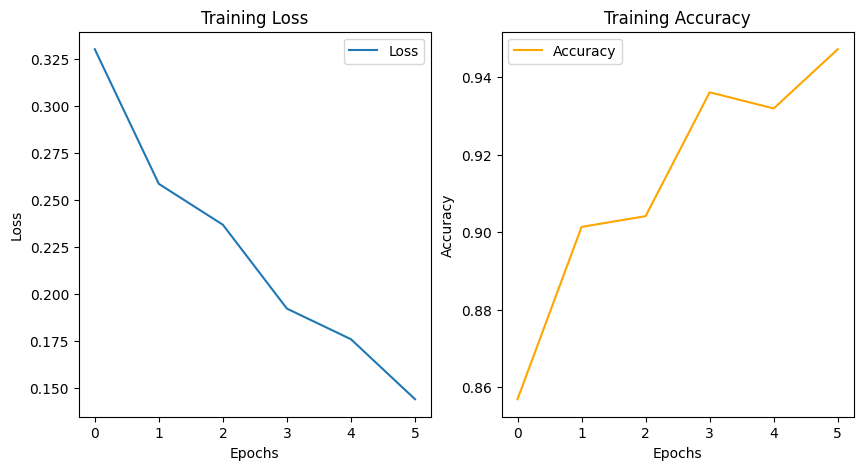

In [28]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accs, label='Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [29]:
def evaluate_model():
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions = (outputs >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

evaluate_model()


Test Loss: 1.1780, Test Accuracy: 0.7350


Exercise 2. Sentiment Analysis


In [59]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
from textblob import TextBlob

# text
sentence = """The larger Broncos will be available with 35-inch off-road tires and will be able
to drive through water nearly 3 feet, 10 inches deep. It has independent front suspension, unlike its main competitor, the Jeep Wrangler. Independent suspension, used
on almost all modern passenger vehicles, generally provides a smoother ride and better on -road handling than a single solid axle. It still has a solid axle in the back though, like most
pickup trucks, a design suited to hard use. Like the Wrangler, both the two- and four-door
Bronco will have a removable roofs and doors. Buyers will be able to choose either a hard
roof that can be removed in sections, a cloth top, or both. Unlike the Wrangler, though, the
Bronco's doors will fit inside the vehicle after being removed. The Bronco will be available
with a choice of either a 10-speed automatic or seven-speed manual transmission. (The
manual transmission will have six gears for ordinary driving, plus a seventh for low speed
off-road driving.) It will be powered by either a 270- horsepower 2.3-liter turbocharged 4-
cylinder engine or a 310-horsepower 2.7-liter turbocharged V6. While all of the new Bronco
SUVs are designed for hard off-road use, the Bronco Sport isn't quite as hard-core in its
capabilities. It also has more convenience features than the more truck-like Bronco. While
it's based on engineering that's similar to car-like crossover SUVs, Ford says that it's still
intended for serious off-road use. Ford engineers boasted of the off-road testing the
prototypes have been put through, including driving through deep sand, up steep inclines ,
and crawling across boulder-strewn trails."""





In [64]:
sentence_cleaned = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)  # Removing special characters
sentence_cleaned = re.sub(r'\s+', ' ', sentence_cleaned)    # Replacing multiple spaces with a single space
sentence_cleaned = re.sub(r'\b\w\b', '', sentence_cleaned)   # Removing single characters
sentence_cleaned = sentence_cleaned.strip().lower()         # Converting to lowercase and strip

# Displaying the cleaned sentence
print(sentence_cleaned)

the larger broncos will be available with 35 inch off road tires and will be able to drive through water nearly  feet 10 inches deep it has independent front suspension unlike its main competitor the jeep wrangler independent suspension used on almost all modern passenger vehicles generally provides  smoother ride and better on road handling than  single solid axle it still has  solid axle in the back though like most pickup trucks  design suited to hard use like the wrangler both the two and four door bronco will have  removable roofs and doors buyers will be able to choose either  hard roof that can be removed in sections  cloth top or both unlike the wrangler though the bronco  doors will fit inside the vehicle after being removed the bronco will be available with  choice of either  10 speed automatic or seven speed manual transmission the manual transmission will have six gears for ordinary driving plus  seventh for low speed off road driving it will be powered by either  270 horse

In [47]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Loading stopwords
stop_words = set(stopwords.words('english'))

# Splittig the cleaned sentence into words
words = sentence_cleaned.split()

# Removing the stopwords
words_filtered = [word for word in words if word not in stop_words]

# Displaying the filtered words
print(words_filtered)

['larger', 'broncos', 'available', '35', 'inch', 'road', 'tires', 'able', 'drive', 'water', 'nearly', 'feet', '10', 'inches', 'deep', 'independent', 'front', 'suspension', 'unlike', 'main', 'competitor', 'jeep', 'wrangler', 'independent', 'suspension', 'used', 'almost', 'modern', 'passenger', 'vehicles', 'generally', 'provides', 'smoother', 'ride', 'better', 'road', 'handling', 'single', 'solid', 'axle', 'still', 'solid', 'axle', 'back', 'though', 'like', 'pickup', 'trucks', 'design', 'suited', 'hard', 'use', 'like', 'wrangler', 'two', 'four', 'door', 'bronco', 'removable', 'roofs', 'doors', 'buyers', 'able', 'choose', 'either', 'hard', 'roof', 'removed', 'sections', 'cloth', 'top', 'unlike', 'wrangler', 'though', 'bronco', 'doors', 'fit', 'inside', 'vehicle', 'removed', 'bronco', 'available', 'choice', 'either', '10', 'speed', 'automatic', 'seven', 'speed', 'manual', 'transmission', 'manual', 'transmission', 'six', 'gears', 'ordinary', 'driving', 'plus', 'seventh', 'low', 'speed', 'ro

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [58]:
stemmer = PorterStemmer()

In [49]:
# Stemming
words_stemmed = [stemmer.stem(word) for word in words_filtered]

In [52]:
# Lemmatization
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
lemmatizer = WordNetLemmatizer()
words_lemmatized = [lemmatizer.lemmatize(word) for word in words_filtered]

In [56]:
# Sentiment analysis
blob = TextBlob(' '.join(words_lemmatized))
sentiment = blob.sentiment

In [63]:
# Printing the Results
words_filtered, words_stemmed, words_lemmatized

(['larger',
  'broncos',
  'available',
  '35',
  'inch',
  'road',
  'tires',
  'able',
  'drive',
  'water',
  'nearly',
  'feet',
  '10',
  'inches',
  'deep',
  'independent',
  'front',
  'suspension',
  'unlike',
  'main',
  'competitor',
  'jeep',
  'wrangler',
  'independent',
  'suspension',
  'used',
  'almost',
  'modern',
  'passenger',
  'vehicles',
  'generally',
  'provides',
  'smoother',
  'ride',
  'better',
  'road',
  'handling',
  'single',
  'solid',
  'axle',
  'still',
  'solid',
  'axle',
  'back',
  'though',
  'like',
  'pickup',
  'trucks',
  'design',
  'suited',
  'hard',
  'use',
  'like',
  'wrangler',
  'two',
  'four',
  'door',
  'bronco',
  'removable',
  'roofs',
  'doors',
  'buyers',
  'able',
  'choose',
  'either',
  'hard',
  'roof',
  'removed',
  'sections',
  'cloth',
  'top',
  'unlike',
  'wrangler',
  'though',
  'bronco',
  'doors',
  'fit',
  'inside',
  'vehicle',
  'removed',
  'bronco',
  'available',
  'choice',
  'either',
  '10',


In [62]:
sentiment

Sentiment(polarity=0.07005523212419763, subjectivity=0.3943275115688909)